In [16]:
from typing import Tuple, TypeVar
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gpflow
from gpflow.utilities import print_summary
import arviz
import sys
sys.path.append('..')
from utils.utilities import (HMCParameters,create_mala_mcmc, load_single_gene_normalized, create_data, load_data, load_single_gene, load_filtered_data, create_standard_mcmc, create_trcd_model,
                       optimize_with_scipy_optimizer, fit_rbf, predict_trcd,
                       plot_trcd_predict, select_parameters, init_hyperparameters)

from utils.utils_mcmc import (run_mcmc, run_mala, analyse_samples, experiment_print, reset_parameters)
import pymc3
from typing import Callable, List, TypeVar
from trcd.utils import SamplingHelper
gpflow.config.set_default_float(np.float64)  

Scalar = TypeVar("Scalar", tf.Tensor, float)
FullData = Tuple[tf.Tensor, tf.Tensor]
Observations = Tuple[tf.Tensor, tf.Tensor, tf.Tensor]

np.random.seed(100)
tf.random.set_seed(100)

def compute_half_life(D):
    return np.log(2)/D




## Load the data

In [2]:
data1 = pd.read_csv('../data/LB_GP_TS.csv', sep=",")
data2 = pd.read_csv('../data/Exon_intron_counts_data_normalizedbylibrarydepthonly_20200120.txt',sep=" ")
names_transcripts =  pd.read_csv('../data/zygotic_tr_95_genes.csv', sep=";")

t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))
rep_no = 3
t = np.hstack((t0,t0,t0))[:,None]
t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))

In [3]:
'''
Gene and transcripts id's
'''
gene_id = 'FBgn0052227'
tr_id = 'FBtr0074848'

In [4]:
data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id)

## Normalization

mRNA per cell: 122.77; mRNA per TS 16.97; embryo age 175. 

In [5]:
norm_m = 122.77
norm_p = 16.97
time_indexes = np.array([np.where(t == 160)[0],np.where(t == 175)[0],np.where(t == 190)[0]]).flatten()

In [6]:
data, observations, gene_id, data_p, observations_p = load_single_gene_normalized(gene_id, tr_id, time_indexes, norm_m, norm_p)

In [7]:
#data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id, time_indexes, norm_m, norm_p)
data_orig, observations_orig, gene_id_orig, data_p_orig, observations_p_orig = load_single_gene(gene_id, tr_id)

## Create and optimize model with fixed S = 1

In [8]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data, initial_lengthscale, initial_variance, initial_S, transform_base=None)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
dict_parameters = select_parameters(dict_parameters,
                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=964.2998622594869
Step 10 loss=325.0647558435677


In [9]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  0.00540168 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │             │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  1          │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ TRCD.model.kernel.variance    

#### half-life

In [10]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

128.3206946215201

predicted y failed, predicted f


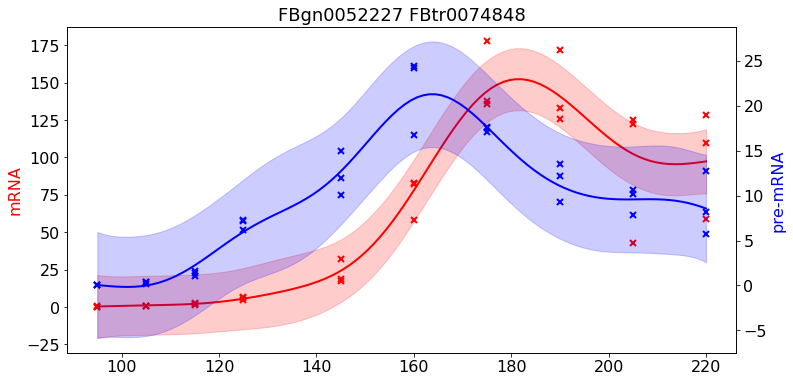

In [11]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations, variance_m, variance_p)

### Run MCMC

In [12]:
parameters = list(dict_parameters.values())

# [Step 0] Run MCMC
# [Step 0] Save results at 'mcmc results mala'
0.001
0.001
     parameter acceptance_rate
0            D             0.0
1     variance             0.0
2  lengthscale             0.0
3   variance_m             0.0
4   variance_p             0.0
     parameter                   MAP               hpd_l               hpd_u
0            D  0.005401678837574658  0.6958516672410816  0.6958516672410816
1     variance      24.5239957584838  24.523995758506153  24.523995758506153
2  lengthscale    15.578031737516099  15.578031909127738  15.578031909127738
3   variance_m     47.67855274785766   47.67855274785766   47.67855274785766
4   variance_p    3.7136650095321166   3.737760348287092   3.737760348287092


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


# [Step 0] MCMC finished
# [Step 1] Run MCMC
# [Step 1] Save results at 'mcmc results mala'
0.07
0.07
     parameter acceptance_rate
0            D             0.0
1     variance             0.0
2  lengthscale             0.0
3   variance_m             0.0
4   variance_p             0.0
     parameter                   MAP               hpd_l               hpd_u
0            D  0.005401678837574658  0.7830865595444441  0.7830865595444441
1     variance      24.5239957584838   24.52012680647265   24.52012680647265
2  lengthscale    15.578031737516099  15.444860689492426  15.444860689492426
3   variance_m     47.67855274785766   47.73383558750016   47.73383558750016
4   variance_p    3.7136650095321166  3.7348954942969668  3.7348954942969668


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


# [Step 1] MCMC finished
# [Step 2] Run MCMC
# [Step 2] Save results at 'mcmc results mala'
0.05
0.05
     parameter acceptance_rate
0            D           1e-05
1     variance           1e-05
2  lengthscale           1e-05
3   variance_m           1e-05
4   variance_p           1e-05
     parameter                   MAP                hpd_l               hpd_u
0            D  0.005401678837574658  0.06203221897288579  0.6931471805599453
1     variance      24.5239957584838   24.486840463721848  24.588198110781835
2  lengthscale    15.578031737516099   0.6931471805600408  3.8579334471969076
3   variance_m     47.67855274785766    49.50909585872691   50.38416238647896
4   variance_p    3.7136650095321166   3.4724226788588353   3.537931739849577


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


# [Step 2] MCMC finished
# [Step 3] Run MCMC
# [Step 3] Save results at 'mcmc results mala'
0.1
0.1
     parameter acceptance_rate
0            D         0.96225
1     variance         0.96225
2  lengthscale         0.96225
3   variance_m         0.96225
4   variance_p         0.96225


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


     parameter                   MAP                 hpd_l  \
0            D  0.005401678837574658  5.45712428003779e-07   
1     variance      24.5239957584838     23.60242869169506   
2  lengthscale    15.578031737516099    13.653673620602444   
3   variance_m     47.67855274785766     44.06872207512513   
4   variance_p    3.7136650095321166    2.8146893676249682   

                  hpd_u  
0  0.009983012384024915  
1     25.46900882730699  
2    17.693493578483984  
3     51.48135940789908  
4     4.785909173849747  
# [Step 3] MCMC finished


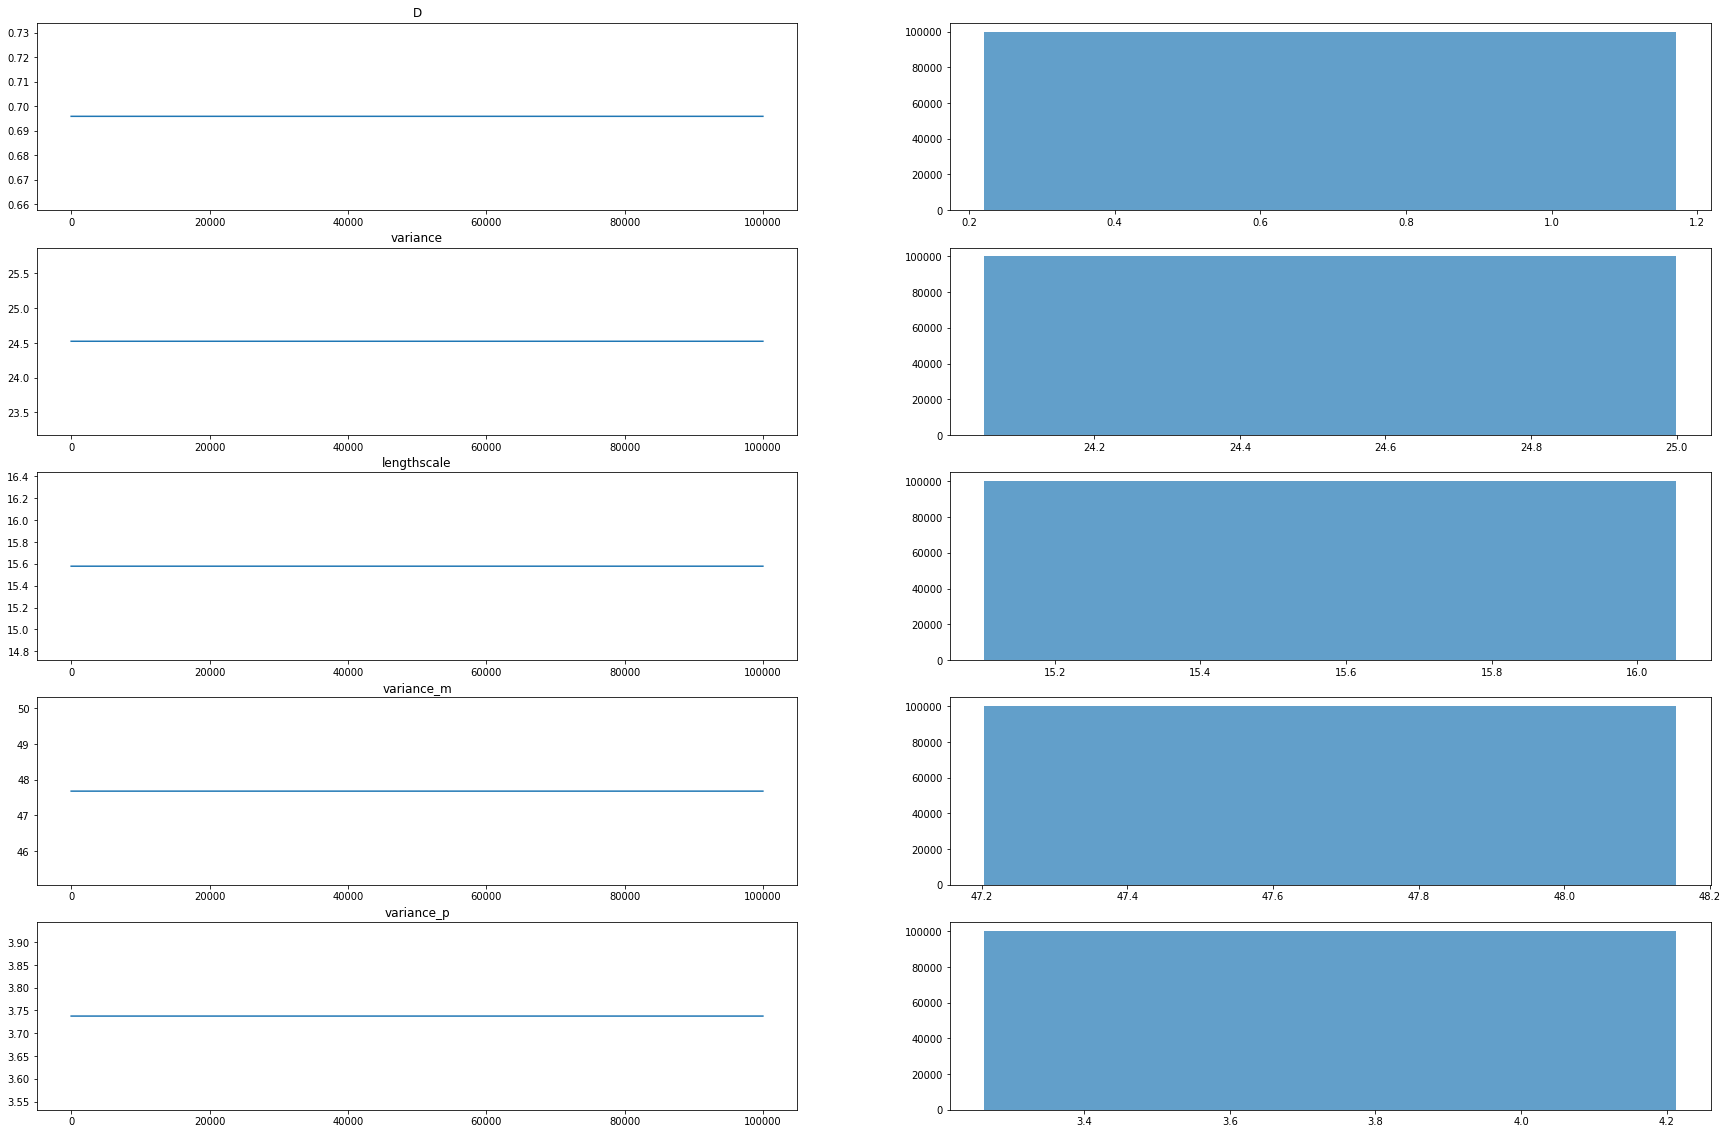

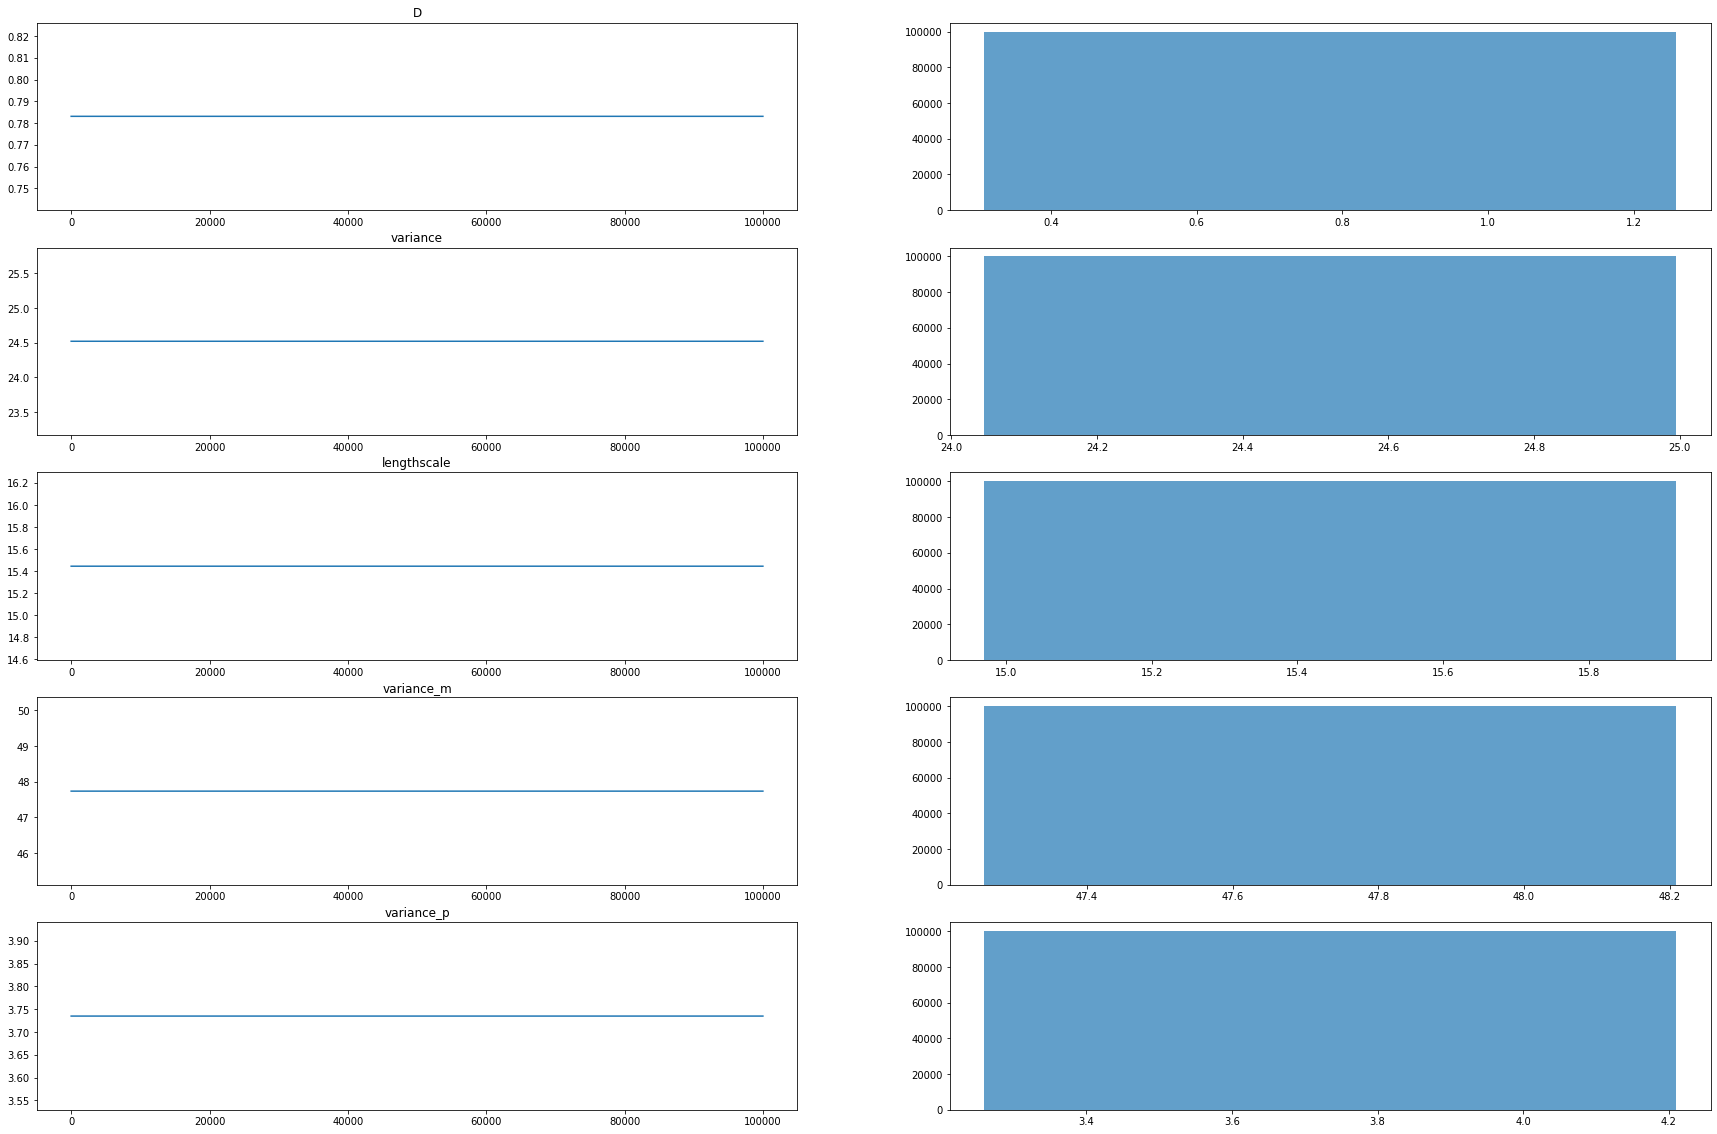

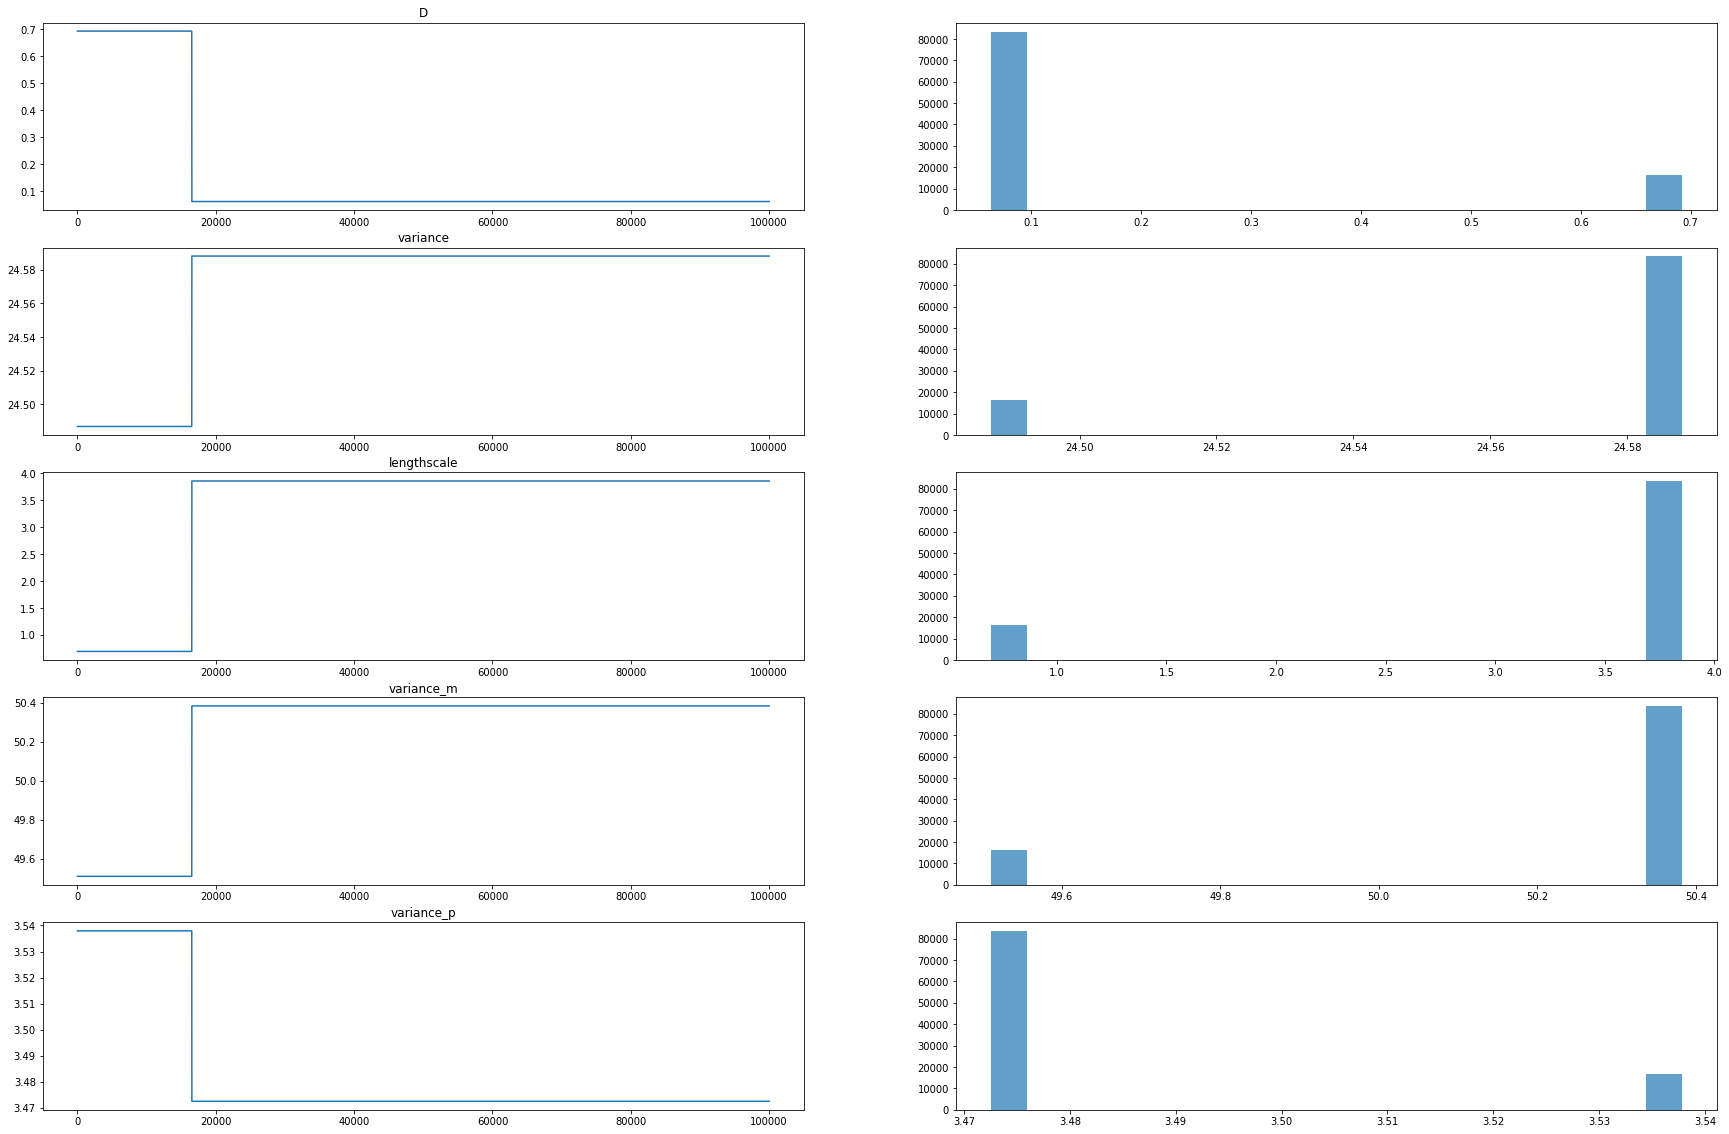

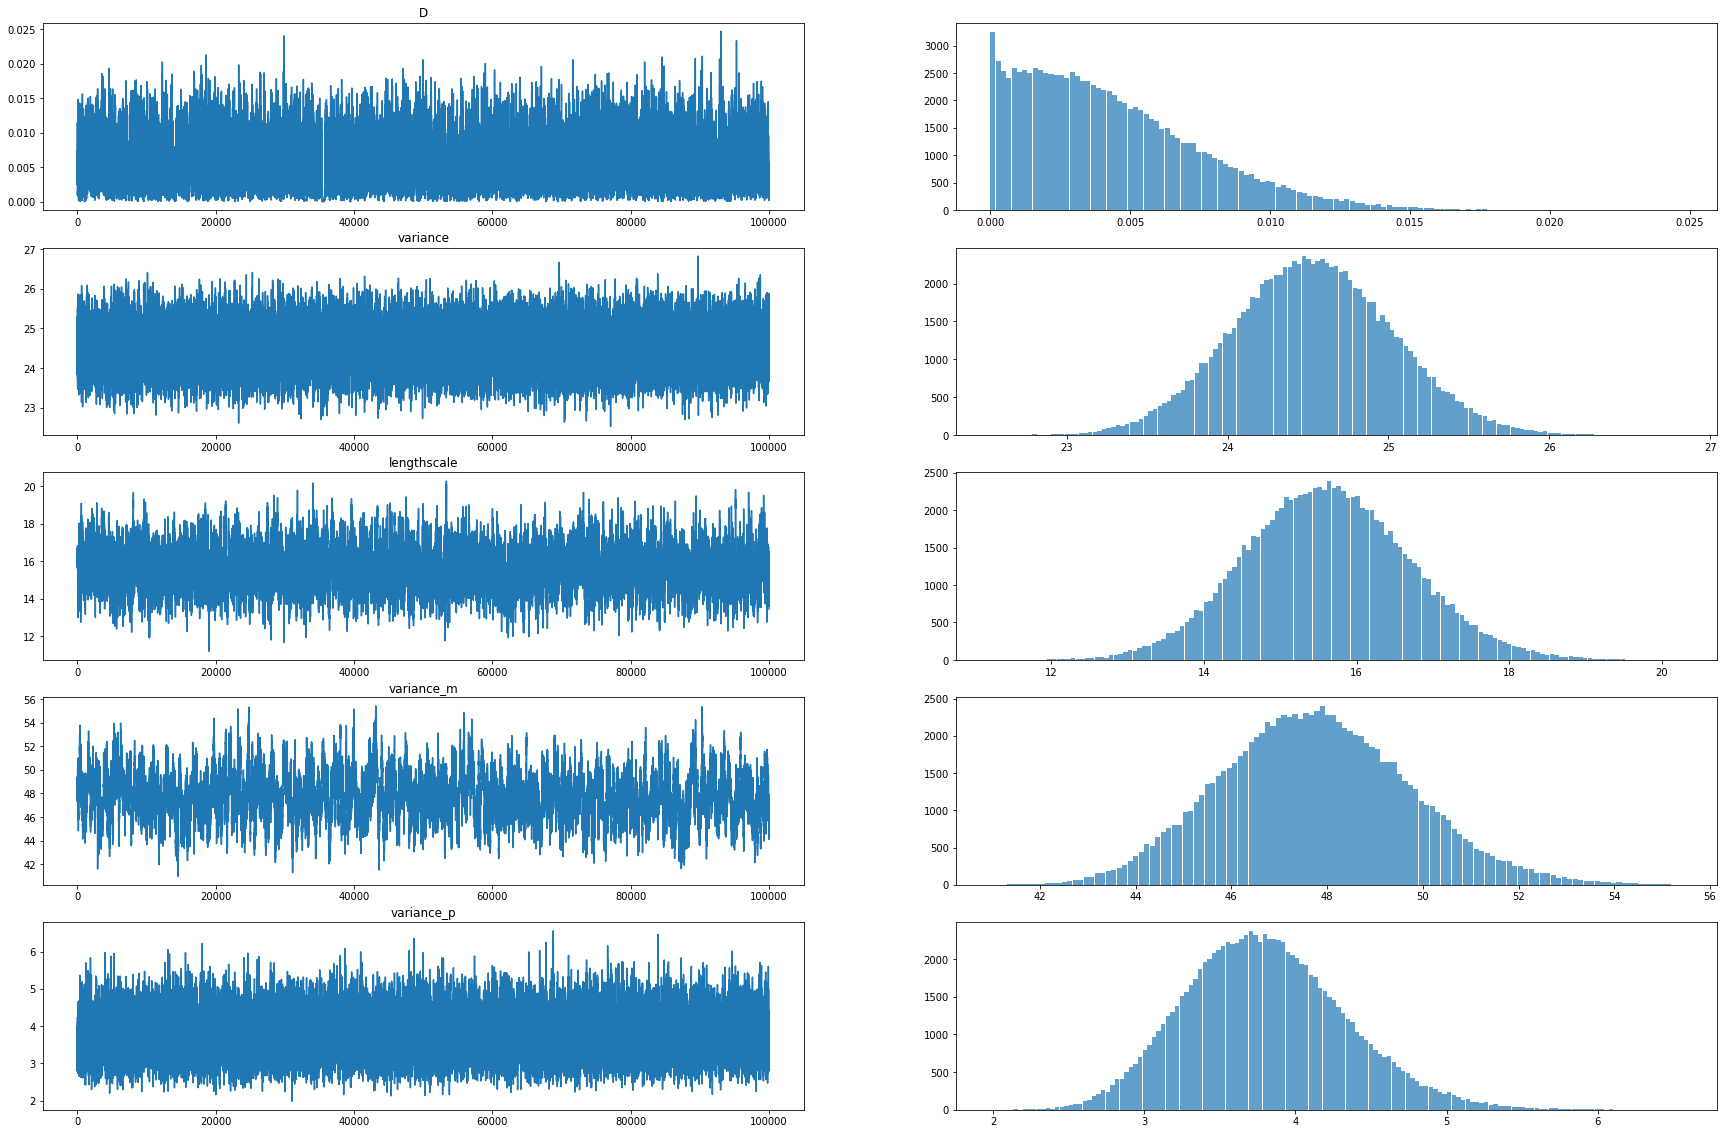

In [13]:
np.random.seed(100)
tf.random.set_seed(100)
from pathlib import Path
parameters_vector = tf.stack(parameters)
hmc_parameters = HMCParameters(num_samples=1000, num_burnin_steps=1000)
hmc_helper, run_chain = create_mala_mcmc(trcd, parameters, hmc_parameters)
gpflow.config.set_default_positive_minimum(1e-6)
#step_size_mala = np.array([ 10**-5 , 10**-4 , 10**-3 , 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 1])
step_size_mala = np.array([ 0.001 , 0.07 , 0.05,  0.1 ])
for j in range(step_size_mala.shape[0]):
    step_size = step_size_mala[j]
    #pathname = f"different gene results mala-{step_size}"
    try:
        experiment_print(j, "Run MCMC")
        step_size = step_size_mala[j]
        #num_leapfrog, step_size = leapfrog_num_and_step_size[j]
        pathname = f"mcmc results mala"
        experiment_print(j, f"Save results at '{pathname}'")

        samples = run_mala(run_chain,
                               hmc_helper,
                               step_size=step_size_mala[j])
        analyse_samples(gene_id, tr_id, parameters_vector, step_size, *samples, dict_parameters=dict_parameters, pathname=pathname)
            #reset_parameters(parameters, initial_values)
        experiment_print(j, f"MCMC finished")
    except:
        print('Experiment error')

In [56]:
pathname = f"mcmc results mala/hpd_"+str(gene_id)+'_'+str(tr_id)+'_step_size0.05.csv'
df = pd.read_csv(pathname)

In [57]:
df

,Unnamed: 0,parameter,MAP,hpd_l,hpd_u
0,0,D,0.005402,0.062032,0.693147
1,1,variance,24.523996,24.486840,24.588198
2,2,lengthscale,15.578032,0.693147,3.857933
3,3,variance_m,47.678553,49.509096,50.384162
4,4,variance_p,3.713665,3.472423,3.537932


## Original data

In [60]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data_orig, initial_lengthscale, initial_variance, initial_S, transform_base=None)
dict_parameters = select_parameters(dict_parameters,
                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=325.175865689653
Step 10 loss=286.71632894242566


In [61]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                             │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ TRCD.D                           │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │   0.0278324 │
│ TRCD.model.kernel.D              │           │                  │         │             │         │         │             │
├──────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │   0.410965  │
├──────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────

### half-life

In [62]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

24.90428600253239

predicted y failed, predicted f


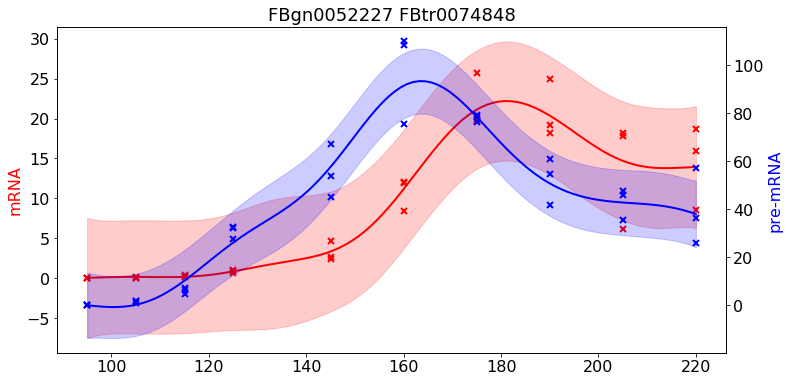

In [63]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations_orig, variance_m, variance_p)

### Run MCMC 

In [64]:
parameters = list(dict_parameters.values())

In [ ]:
np.random.seed(100)
tf.random.set_seed(100)
from pathlib import Path
parameters_vector = tf.stack(parameters)
hmc_parameters = HMCParameters(num_samples=1000, num_burnin_steps=1000)
hmc_helper, run_chain = create_mala_mcmc(trcd, parameters, hmc_parameters)
gpflow.config.set_default_positive_minimum(1e-6)
#step_size_mala = np.array([ 10**-5 , 10**-4 , 10**-3 , 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 1])
step_size_mala = np.array([ 0.001 , 0.07 , 0.05,  0.1 ])
for j in range(step_size_mala.shape[0]):
    step_size = step_size_mala[j]
    #pathname = f"different gene results mala-{step_size}"
    try:
        experiment_print(j, "Run MCMC")
        step_size = step_size_mala[j]
        #num_leapfrog, step_size = leapfrog_num_and_step_size[j]
        pathname = f"mcmc results mala"
        experiment_print(j, f"Save results at '{pathname}'")

        samples = run_mala(run_chain,
                               hmc_helper,
                               step_size=step_size_mala[j])
        analyse_samples(gene_id, tr_id, parameters_vector, step_size, *samples, dict_parameters=dict_parameters, pathname=pathname)
            #reset_parameters(parameters, initial_values)
        experiment_print(j, f"MCMC finished")
    except:
        print('Experiment error')

# [Step 0] Run MCMC
# [Step 0] Save results at 'mcmc results mala'
0.001
0.001
     parameter acceptance_rate
0            D             0.0
1            S             0.0
2     variance             0.0
3  lengthscale             0.0
4   variance_m             0.0
5   variance_p             0.0


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


     parameter                   MAP               hpd_l               hpd_u
0            D  0.027832445406765032  0.7071612307652643  0.7071612307652643
1            S    0.4109645452445845  0.9195950220784529  0.9195950220784529
2     variance    110.44806375705441  110.44806475705441  110.44806475705441
3  lengthscale    16.055358642415374  16.055359748890048  16.055359748890048
4   variance_m     6.066706208951833   6.069023322970843   6.069023322970843
5   variance_p    20.042499833139622  20.042500835115014  20.042500835115014
# [Step 0] MCMC finished
# [Step 1] Run MCMC
# [Step 1] Save results at 'mcmc results mala'
0.07
0.07
     parameter acceptance_rate
0            D             0.0
1            S             0.0
2     variance             0.0
3  lengthscale             0.0
4   variance_m             0.0
5   variance_p             0.0


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


     parameter                   MAP               hpd_l               hpd_u
0            D  0.027832445406765032  0.9410975882554856  0.9410975882554856
1            S    0.4109645452445845  1.2969194952219754  1.2969194952219754
2     variance    110.44806375705441  110.42036379016079  110.42036379016079
3  lengthscale    16.055358642415374  15.987809439490007  15.987809439490007
4   variance_m     6.066706208951833   6.060280946799598   6.060280946799598
5   variance_p    20.042499833139622  20.051579267575974  20.051579267575974
# [Step 1] MCMC finished
# [Step 2] Run MCMC
# [Step 2] Save results at 'mcmc results mala'
Experiment error
# [Step 3] Run MCMC
# [Step 3] Save results at 'mcmc results mala'
0.1
0.1
     parameter acceptance_rate
0            D             0.0
1            S             0.0
2     variance             0.0
3  lengthscale             0.0
4   variance_m             0.0
5   variance_p             0.0
     parameter                   MAP               hpd_l    

/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


In [55]:
df = pd.read_csv('results_mala_processed/hpdFBgn0052227_FBtr0074848.csv')

In [56]:
df

,Unnamed: 0,Unnamed: 0.1,parameter,MAP,hpd_l,hpd_u
0,0,0,D,0.0234,0.0000,0.0524
1,1,1,S,0.3635,0.1895,0.6432
2,2,2,variance,110.8938,108.1771,113.6120
3,3,3,lengthscale,16.0670,14.3370,17.9985
4,4,4,variance_m,5.4732,4.7634,6.2805
5,5,5,variance_p,20.4251,18.9622,21.9362


In [187]:
np.log(2)/np.asarray(0.0)

inf

In [188]:
np.log(2)/np.asarray(0.0524)

13.22799962900659